## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

## Define Dataset

In [ ]:
df = pd.read_csv("/content/heart(1).csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Exploratory Analysis

### Understand Dataset

In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


5 categorical columns.

No null values.

**RestingBP** represents the resting blood pressure (mmHg).  
**Cholesterol** represents the serum cholesterol level (mg/dL).  
**FastingBS** indicates if fasting blood sugar is greater than 120 mg/dL.  
**RestingECG** results of the resting electrocardiogram test.  
**MaxHR** represents the maximum heart rate achieved.  
**ExerciseAngina** indicates if exercise-induced angina is present.  
**Oldpeak** represents the ST depression induced by exercise relative to rest (often used to measure ischemia).  
**ST_Slope** represents the slope of the peak exercise ST segment.  
**HeartDisease** is the target column

#### Describe numerical columns

In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Oldpeak has negative values.

#### Describe categorical columns

In [ ]:
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())
    print()

Sex
['M' 'F']

ChestPainType
['ATA' 'NAP' 'ASY' 'TA']

RestingECG
['Normal' 'ST' 'LVH']

ExerciseAngina
['N' 'Y']

ST_Slope
['Up' 'Flat' 'Down']



**ChestPainType**:
ATA (Atypical Angina),
NAP (Non-Anginal Pain),
ASY (Asymptomatic),
TA (Typical Angina)

**RestingECG**:
Normal,
ST (ST-segment depression or elevation),
LVH (Left Ventricular Hypertrophy)

#### Drop duplicates

In [ ]:
df.duplicated().sum()

0

We don't have duplicates

In [ ]:


def handle_outliers(df, features, threshold=3):

    for feature in features:
        z_scores = zscore(df[feature])
        outliers = (z_scores > threshold) | (z_scores < -threshold)
        print(f"{outliers.sum()} outliers detected in '{feature}':")
        print(df[feature][outliers])
        print("-" * 50)
        # Replace outliers with NaN
        df.loc[outliers, feature] = np.nan



    return df


In [ ]:
def handle_infrequent_categories(df, column, threshold):

    value_counts = df[column].value_counts()
    print(value_counts)
    frequent_categories = value_counts[value_counts >= threshold].index
    df[column] = df[column].apply(lambda x: x if x in frequent_categories else 'Other')  # Replace infrequent categories
    return df

In [ ]:

Numerical_Features = df.select_dtypes(exclude=['object']).columns.tolist()
Numerical_Features = [feature for feature in Numerical_Features if feature != 'HeartDisease']

print(Numerical_Features)
Categorical_Features = df.select_dtypes(include=['object']).columns.tolist()

for col in Categorical_Features:
    df = handle_infrequent_categories(df, col, 30)




['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Sex
M    725
F    193
Name: count, dtype: int64
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64


In [ ]:
imputer = KNNImputer(weights = 'uniform')
df[Numerical_Features] = imputer.fit_transform(df[Numerical_Features])

In [ ]:

    df= handle_outliers(df, Numerical_Features)

0 outliers detected in 'Age':
Series([], Name: Age, dtype: float64)
--------------------------------------------------
8 outliers detected in 'RestingBP':
109    190.0
241    200.0
365    200.0
399    200.0
449      0.0
592    190.0
732    200.0
759    192.0
Name: RestingBP, dtype: float64
--------------------------------------------------
3 outliers detected in 'Cholesterol':
76     529.0
149    603.0
616    564.0
Name: Cholesterol, dtype: float64
--------------------------------------------------
0 outliers detected in 'FastingBS':
Series([], Name: FastingBS, dtype: float64)
--------------------------------------------------
1 outliers detected in 'MaxHR':
390    60.0
Name: MaxHR, dtype: float64
--------------------------------------------------
7 outliers detected in 'Oldpeak':
166    5.0
324   -2.6
702    4.2
771    5.6
791    4.2
850    6.2
900    4.4
Name: Oldpeak, dtype: float64
--------------------------------------------------


In [ ]:
imputer = KNNImputer(weights = 'uniform')
df[Numerical_Features] = imputer.fit_transform(df[Numerical_Features])

In [ ]:
labelEncoder = LabelEncoder()
for column in Categorical_Features:
    print(column)
    df[column]=labelEncoder.fit_transform(df[column])


Sex
ChestPainType
RestingECG
ExerciseAngina
ST_Slope


In [ ]:
scaler = StandardScaler()
df[Numerical_Features] = scaler.fit_transform(df[Numerical_Features])

print(df.head())

        Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.433140    1              1   0.461794     0.852067  -0.551341   
1 -0.478484    0              2   1.630346    -0.163324  -0.551341   
2 -1.751359    1              1  -0.122481     0.796174  -0.551341   
3 -0.584556    0              0   0.344939     0.153404  -0.551341   
4  0.051881    1              2   1.046070    -0.023591  -0.551341   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0           1  1.386793               0 -0.859456         2             0  
1           1  0.754903               0  0.133647         1             1  
2           2 -1.535697               0 -0.859456         2             0  
3           1 -1.140766               1  0.630199         1             1  
4           1 -0.587862               0 -0.859456         2             0  


In [ ]:
#####ask el label ddonitw eh

In [ ]:
# tl3 bayes 3ayez label catogorical
df['HeartDisease'] = df['HeartDisease'].map({0: 'Malak_S', 1: 'Mariam_V'})
print(df.head())

        Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.433140    1              1   0.461794     0.852067  -0.551341   
1 -0.478484    0              2   1.630346    -0.163324  -0.551341   
2 -1.751359    1              1  -0.122481     0.796174  -0.551341   
3 -0.584556    0              0   0.344939     0.153404  -0.551341   
4  0.051881    1              2   1.046070    -0.023591  -0.551341   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope HeartDisease  
0           1  1.386793               0 -0.859456         2      Malak_S  
1           1  0.754903               0  0.133647         1     Mariam_V  
2           2 -1.535697               0 -0.859456         2      Malak_S  
3           1 -1.140766               1  0.630199         1     Mariam_V  
4           1 -0.587862               0 -0.859456         2      Malak_S  


In [ ]:

X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Split data into training (60%), validation (20%), and testing (20%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    float64
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    float64
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    float64
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    object 
dtypes: float64(6), int64(5), object(1)
memory usage: 86.2+ KB


#Hyper parameter tuning for SVM

In [ ]:
# hyperparameter grids
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 0.01, 0.001]
}

In [ ]:
# Set up GridSearchCV for SVM
svm_model = SVC(random_state=42)
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, scoring='f1_weighted', cv=5)

In [ ]:
svm_grid_search.fit(X_train, y_train)

# Get best parameters and evaluate
print("Best parameters for SVM:", svm_grid_search.best_params_)
best_svm_model = svm_grid_search.best_estimator_
y_val_pred_svm = best_svm_model.predict(X_val)
f1_svm = f1_score(y_val, y_val_pred_svm, average='weighted')
print(f"SVM F1-score with GridSearch: {f1_svm}")

Best parameters for SVM: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
SVM F1-score with GridSearch: 0.8535881103485008


In [ ]:
# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Validation Performance:")
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


Hyper Parameter tuning for Bayes

Best parameters for Naïve Bayes: {'var_smoothing': 1e-09}
Naïve Bayes F1-score with GridSearch: 0.859098037597243

Tuned SVM Validation Performance:
              precision    recall  f1-score   support

     Malak_S       0.82      0.87      0.84        82
    Mariam_V       0.89      0.84      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184

Accuracy: 0.8532608695652174


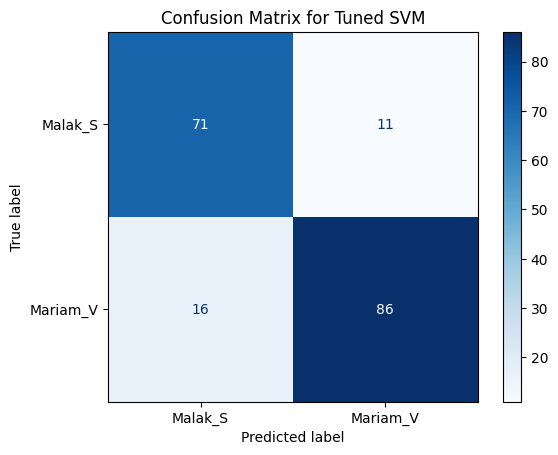


Tuned Naïve Bayes Validation Performance:
              precision    recall  f1-score   support

     Malak_S       0.81      0.89      0.85        82
    Mariam_V       0.90      0.83      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.8586956521739131


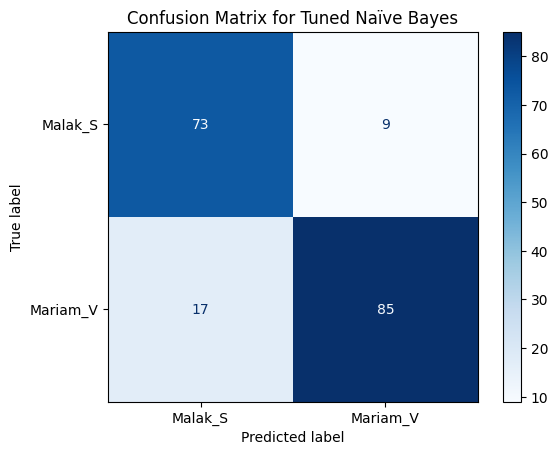


Final Test Performance (Tuned SVM):

Tuned SVM Validation Performance:
              precision    recall  f1-score   support

     Malak_S       0.86      0.80      0.83        82
    Mariam_V       0.85      0.89      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

Accuracy: 0.8532608695652174


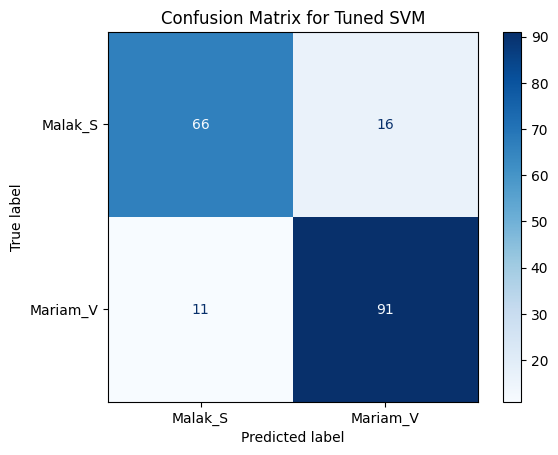


Final Test Performance (Tuned Naïve Bayes):

Tuned Naïve Bayes Validation Performance:
              precision    recall  f1-score   support

     Malak_S       0.84      0.80      0.82        82
    Mariam_V       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

Accuracy: 0.842391304347826


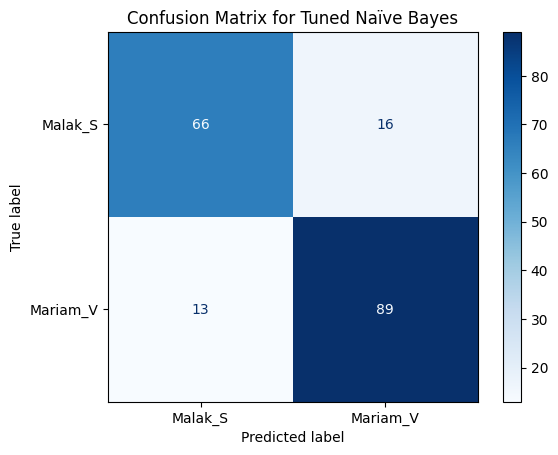

In [ ]:
# Define hyperparameter grids for Naive Bayes
nb_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

# Set up GridSearchCV for Naïve Bayes
nb_model = GaussianNB()
nb_grid_search = GridSearchCV(estimator=nb_model, param_grid=nb_param_grid, scoring='f1_weighted', cv=5)

# Fit the grid search model
nb_grid_search.fit(X_train, y_train)

# Get best parameters and evaluate
print("Best parameters for Naïve Bayes:", nb_grid_search.best_params_)
best_nb_model = nb_grid_search.best_estimator_
y_val_pred_nb = best_nb_model.predict(X_val)
f1_nb = f1_score(y_val, y_val_pred_nb, average='weighted')
print(f"Naïve Bayes F1-score with GridSearch: {f1_nb}")

# Evaluate the tuned models
evaluate_model(y_val, y_val_pred_svm, "Tuned SVM")
evaluate_model(y_val, y_val_pred_nb, "Tuned Naïve Bayes")

# Final Evaluation on Test Set
print("\nFinal Test Performance (Tuned SVM):")
y_test_pred_svm = best_svm_model.predict(X_test)
evaluate_model(y_test, y_test_pred_svm, "Tuned SVM")

print("\nFinal Test Performance (Tuned Naïve Bayes):")
y_test_pred_nb = best_nb_model.predict(X_test)
evaluate_model(y_test, y_test_pred_nb, "Tuned Naïve Bayes")

In [ ]:
# Train Naïve Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_val_pred_nb = nb_model.predict(X_val)
f1_nb = f1_score(y_val, y_val_pred_nb, average='weighted')
print(f"Naïve Bayes F1-score: {f1_nb}")


Naïve Bayes F1-score: 0.859098037597243


In [ ]:

# Train SVM
svm_model = SVC(kernel="linear", C=1, random_state=42)
svm_model.fit(X_train, y_train)
y_val_pred_svm = svm_model.predict(X_val)
f1_svm = f1_score(y_val, y_val_pred_svm, average='weighted')
print(f"SVM F1-score: {f1_svm}")


SVM F1-score: 0.848205843602263



Naïve Bayes Validation Performance:
              precision    recall  f1-score   support

     Malak_S       0.81      0.89      0.85        82
    Mariam_V       0.90      0.83      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.8586956521739131


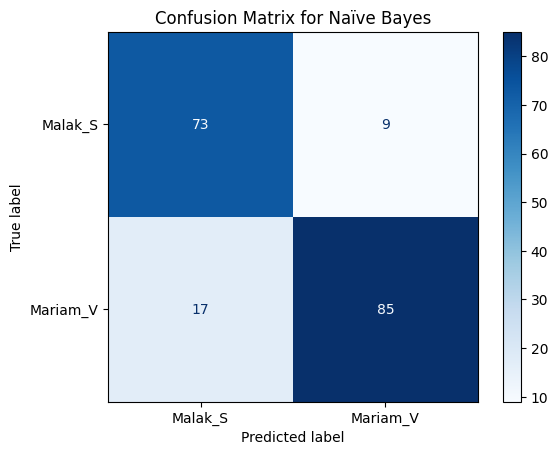


SVM Validation Performance:
              precision    recall  f1-score   support

     Malak_S       0.81      0.87      0.84        82
    Mariam_V       0.89      0.83      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

Accuracy: 0.8478260869565217


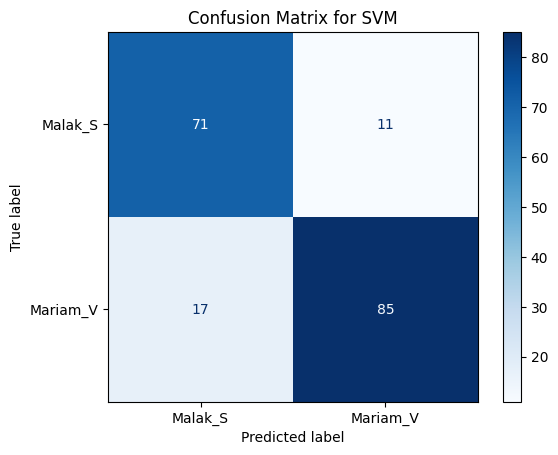


Final Test Performance (Naïve Bayes):

Naïve Bayes Validation Performance:
              precision    recall  f1-score   support

     Malak_S       0.84      0.80      0.82        82
    Mariam_V       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

Accuracy: 0.842391304347826


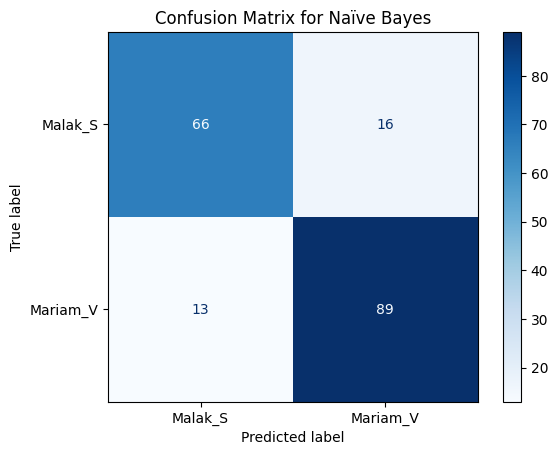


Final Test Performance (SVM):

SVM Validation Performance:
              precision    recall  f1-score   support

     Malak_S       0.86      0.79      0.82        82
    Mariam_V       0.84      0.89      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184

Accuracy: 0.8478260869565217


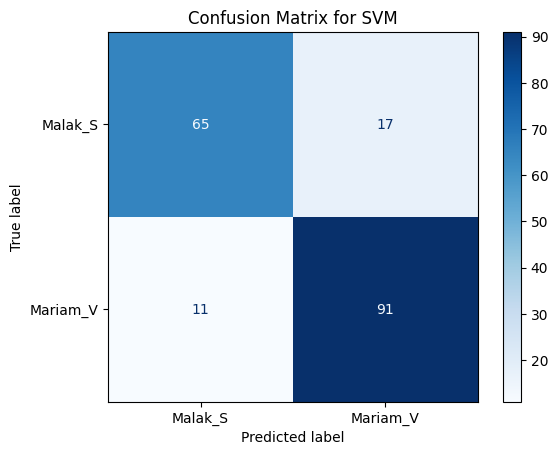

In [ ]:

# Evaluate on Validation Set
evaluate_model(y_val, y_val_pred_nb, "Naïve Bayes")
evaluate_model(y_val, y_val_pred_svm, "SVM")

# Final Evaluation on Test Set
print("\nFinal Test Performance (Naïve Bayes):")
y_test_pred_nb = nb_model.predict(X_test)
evaluate_model(y_test, y_test_pred_nb, "Naïve Bayes")

print("\nFinal Test Performance (SVM):")
y_test_pred_svm = svm_model.predict(X_test)
evaluate_model(y_test, y_test_pred_svm, "SVM")

#**hehehehe as much as i recall fadel histogram and dendogram for this phase if exists t**

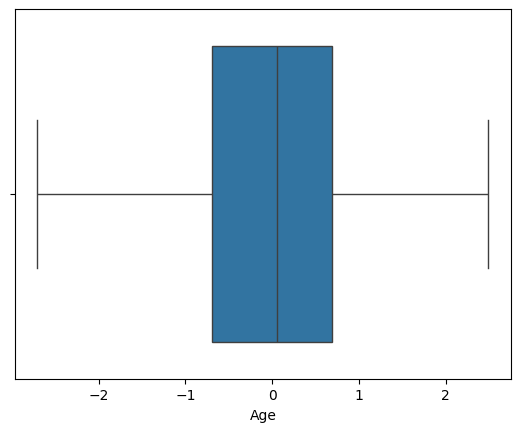

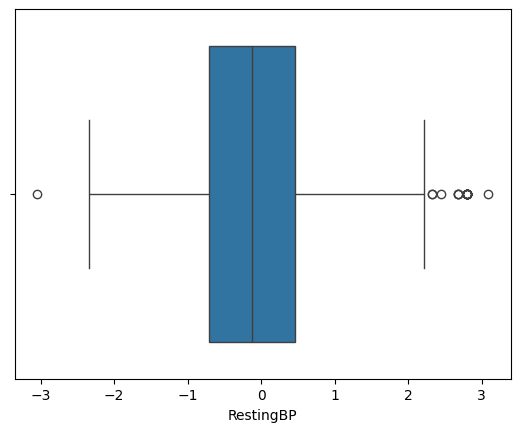

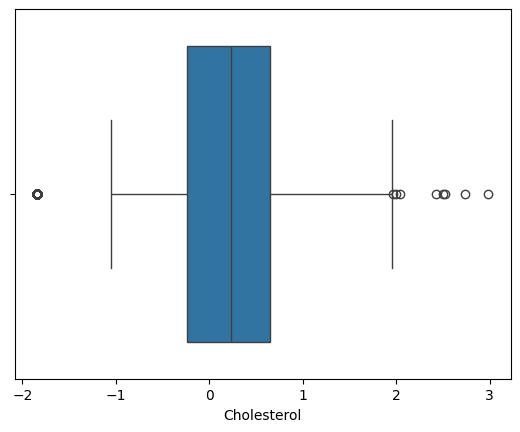

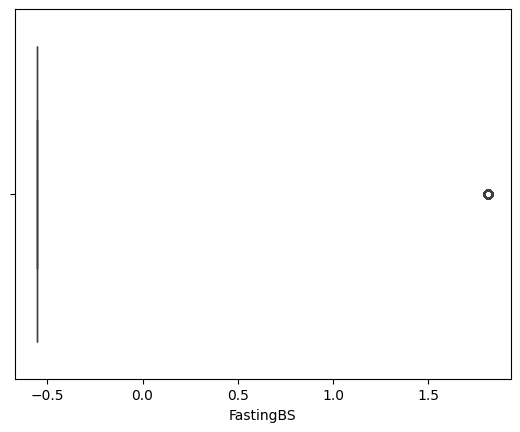

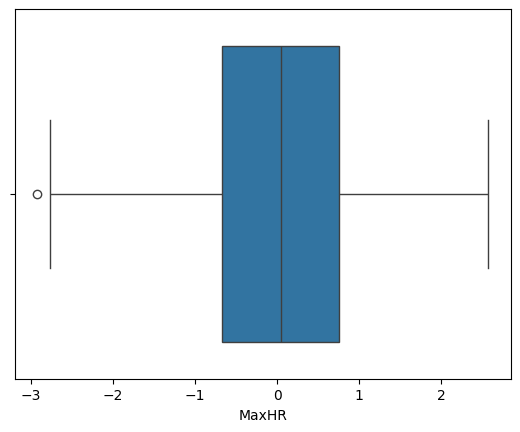

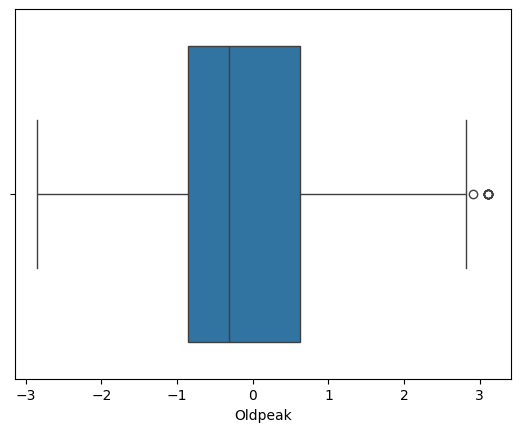

In [ ]:
import seaborn as sns
for feature in Numerical_Features:
    sns.boxplot(data=df, x=feature)
    plt.show()
